## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import librosa
import optuna
import joblib
import os

from IPython import display

# feature engineering + selection
from glob import glob
from librosa import feature
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

# modelling + evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
base_audio_files = glob('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/*.wav')

all_audio = {}

for audio_file in base_audio_files:
    # extract filename from path
    filename = audio_file.split('\\')[-1] # for Windows paths

    # load audio file
    y, sr = librosa.load(audio_file, mono=True)
    
    # store in dictionary
    all_audio[filename] = {
        'data': y,
        'sample_rate': sr
    }

print(f'Loaded {len(all_audio)} audio files')

Loaded 920 audio files


In [3]:
list(all_audio.keys())[:5]

['/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/162_1b2_Ar_mc_AKGC417L.wav',
 '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/193_1b2_Pl_mc_AKGC417L.wav',
 '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/138_2p2_Ll_mc_AKGC417L.wav',
 '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/207_2b2_Ar_mc_AKGC417L.wav',
 '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/176_2b3_Pr_mc_AKGC417L.wav']

## 2. Data Preprocessing

Shortest audio file: /kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/124_1b1_Pr_sc_Litt3200.wav
Duration: 7.86 seconds


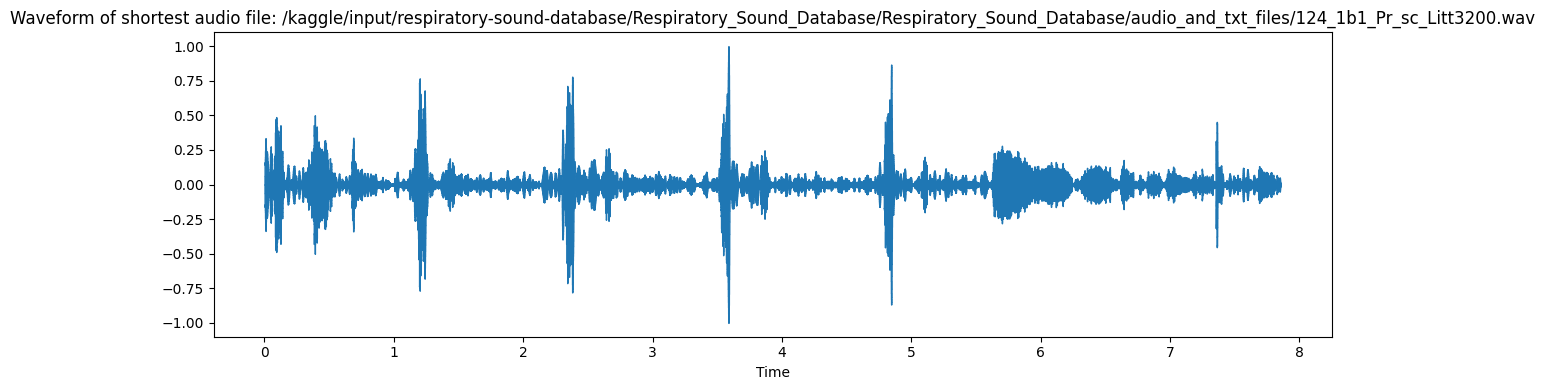

In [4]:
# calculate duration for each audio file
for filename, audio_info in all_audio.items():
    duration = len(audio_info['data']) / audio_info['sample_rate']
    all_audio[filename]['duration'] = duration

# find the file with the minimum duration
min_duration_file = min(all_audio.items(), key=lambda x: x[1]['duration'])
min_filename = min_duration_file[0]
min_audio_info = min_duration_file[1]

print(f"Shortest audio file: {min_filename}")
print(f"Duration: {min_audio_info['duration']:.2f} seconds")

# plot the waveform of the shortest audio file
plt.figure(figsize=(12, 4))
librosa.display.waveshow(min_audio_info['data'], sr=min_audio_info['sample_rate'])
plt.title(f"Waveform of shortest audio file: {min_filename}")
plt.tight_layout()
plt.show()

display.Audio(data=min_audio_info['data'], rate=min_audio_info['sample_rate'])

In [5]:
target_duration = min_audio_info['duration']
print(f"Duration of the shortest audio file: {target_duration} seconds")

trimmed_audio = {}

for filename, audio_info in all_audio.items():
    target_samples = int(target_duration * audio_info['sample_rate']) # calculate target samples
    trimmed_data = audio_info['data'][:target_samples] # trimmed to target duration

    # store in dictionary
    trimmed_audio[filename] = {
        'data': trimmed_data,
        'sample_rate': audio_info['sample_rate'],
        'duration': target_duration
    }

print(f'Trimmed all {len(trimmed_audio)} audio files to {target_duration} seconds')

Duration of the shortest audio file: 7.8560090702947845 seconds
Trimmed all 920 audio files to 7.8560090702947845 seconds


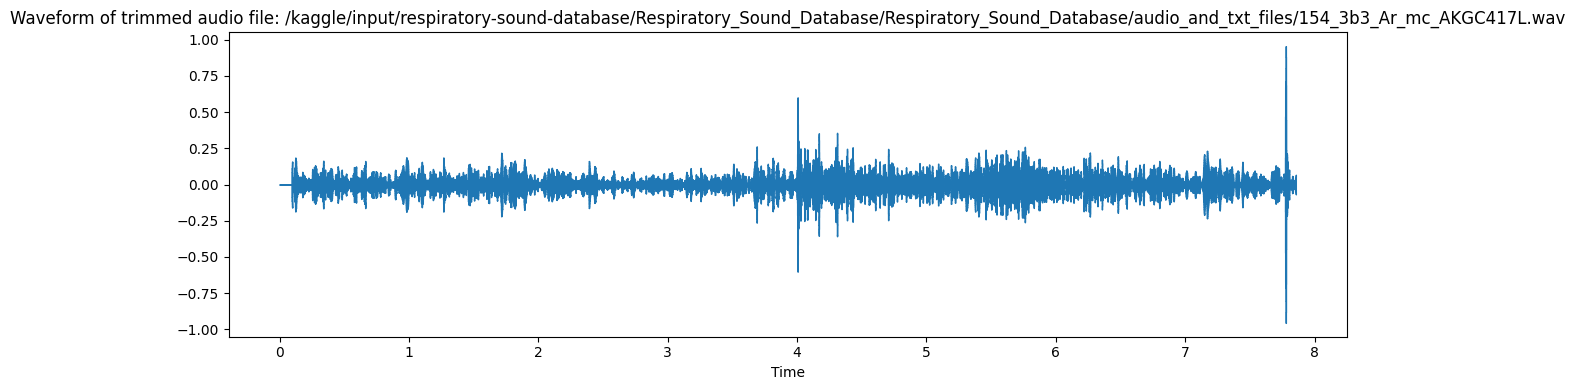

In [6]:
# plot the waveform of a sample trimmed audio file
sample_file = list(trimmed_audio.keys())[90]
plt.figure(figsize=(12, 4))
librosa.display.waveshow(trimmed_audio[sample_file]['data'], sr=trimmed_audio[sample_file]['sample_rate'])
plt.title(f"Waveform of trimmed audio file: {sample_file}")
plt.tight_layout()
plt.show()

## 3. Feature Extraction

In [7]:
fn_list = [
    feature.chroma_stft,       # Chromagram from STFT
    feature.mfcc,              # Mel-frequency cepstral coefficients
    feature.melspectrogram,    # Mel-scaled spectrogram
    feature.spectral_contrast, # Spectral contrast
    feature.tonnetz,           # Tonal centroid features
    feature.rms,               # Root-mean-square energy
    feature.zero_crossing_rate,# Zero crossing rate
    feature.spectral_bandwidth,# Spectral bandwidth
    feature.spectral_centroid, # Spectral centroid
    feature.spectral_flatness, # Spectral flatness
    feature.spectral_rolloff,  # Spectral roll-off
    feature.poly_features,     # Polynomial features
    feature.tempogram          # Tempogram
]

audio_features = {}

# extract features for each audio file
for filename, audio_info in trimmed_audio.items():
    y = audio_info['data']
    sr = audio_info['sample_rate']
    
    audio_features[filename] = {}
    
    audio_features[filename]['chroma_stft'] = feature.chroma_stft(y=y, sr=sr)
    audio_features[filename]['mfcc'] = feature.mfcc(y=y, sr=sr, n_mfcc=13)
    audio_features[filename]['mel_spectrogram'] = feature.melspectrogram(y=y, sr=sr)
    audio_features[filename]['spectral_contrast'] = feature.spectral_contrast(y=y, sr=sr)
    audio_features[filename]['spectral_centroid'] = feature.spectral_centroid(y=y, sr=sr)
    audio_features[filename]['spectral_bandwidth'] = feature.spectral_bandwidth(y=y, sr=sr)
    audio_features[filename]['spectral_rolloff'] = feature.spectral_rolloff(y=y, sr=sr)
    audio_features[filename]['zero_crossing_rate'] = feature.zero_crossing_rate(y=y)

In [8]:
# display feature shape for first file
sample_file = list(audio_features.keys())[0]
for feature_name, feature_data in audio_features[sample_file].items():
    print(f"{feature_name}: {feature_data.shape}")

chroma_stft: (12, 339)
mfcc: (13, 339)
mel_spectrogram: (128, 339)
spectral_contrast: (7, 339)
spectral_centroid: (1, 339)
spectral_bandwidth: (1, 339)
spectral_rolloff: (1, 339)
zero_crossing_rate: (1, 339)


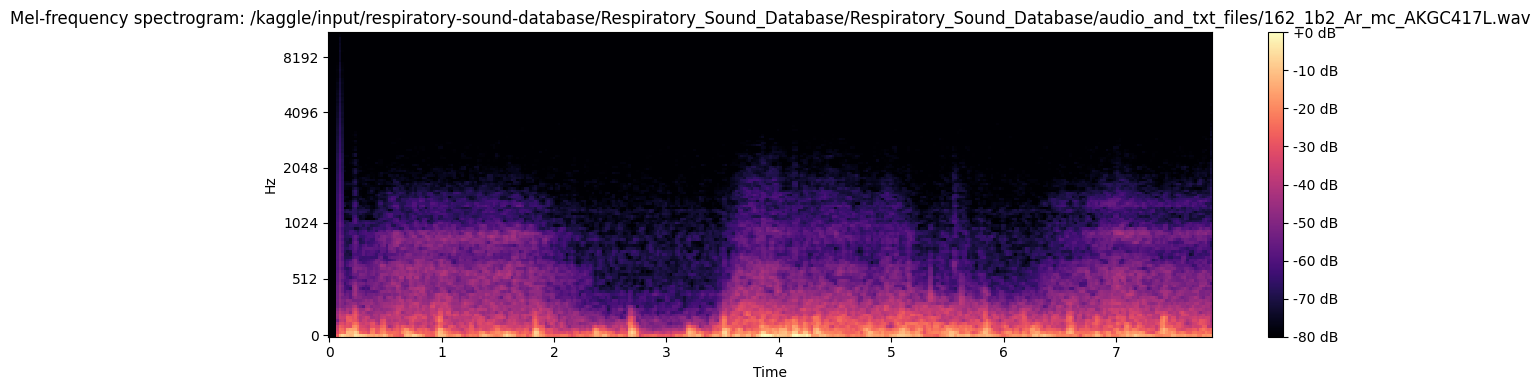

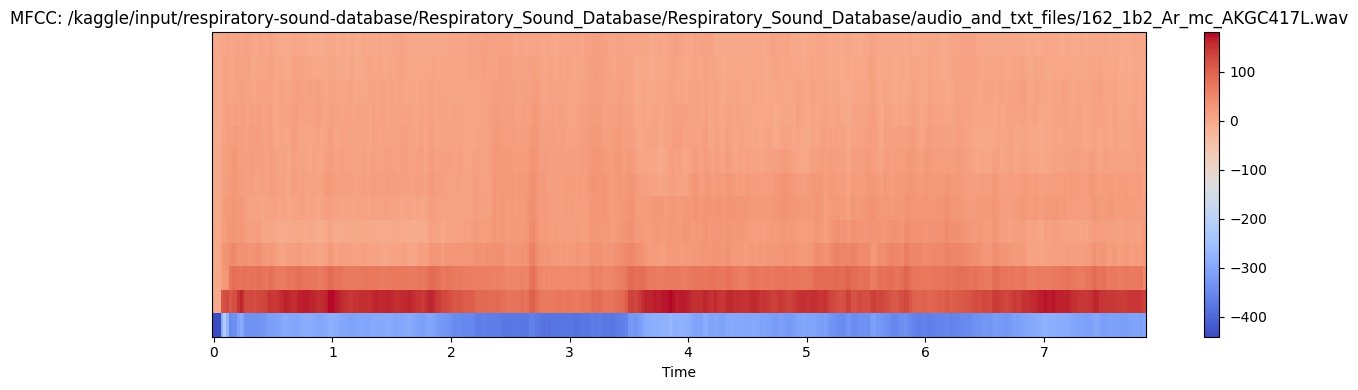

In [9]:
# sample file to visualize
sample_file = list(audio_features.keys())[0]
sample_data = trimmed_audio[sample_file]['data']
sample_sr = trimmed_audio[sample_file]['sample_rate']

# plot mel spectrogram
plt.figure(figsize=(12, 4))
S = librosa.feature.melspectrogram(y=sample_data, sr=sample_sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram: {sample_file}')
plt.tight_layout()
plt.show()

# plot mfccs
plt.figure(figsize=(12, 4))
mfccs = librosa.feature.mfcc(y=sample_data, sr=sample_sr, n_mfcc=13)
librosa.display.specshow(mfccs, x_axis='time', sr=sample_sr)
plt.colorbar()
plt.title(f'MFCC: {sample_file}')
plt.tight_layout()
plt.show()

In [10]:
feature_stats = []

for filename, features in audio_features.items():
    file_stats = {'filename': filename}
    
    # calculate statistics for each feature
    for feature_name, feature_data in features.items():
        file_stats[f'{feature_name}_mean'] = np.mean(feature_data)
        file_stats[f'{feature_name}_std'] = np.std(feature_data)
        file_stats[f'{feature_name}_max'] = np.max(feature_data)
        file_stats[f'{feature_name}_min'] = np.min(feature_data)
    
    feature_stats.append(file_stats)

# create dataframe
df = pd.DataFrame(feature_stats)
df.head()

,filename,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,mfcc_mean,mfcc_std,mfcc_max,mfcc_min,mel_spectrogram_mean,...,spectral_bandwidth_max,spectral_bandwidth_min,spectral_rolloff_mean,spectral_rolloff_std,spectral_rolloff_max,spectral_rolloff_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_max,zero_crossing_rate_min
0,/kaggle/input/respiratory-sound-database/Respi...,0.742040,0.197309,1.0,0.0,1.621959,101.480286,180.424835,-440.259369,8.379805,...,2335.810232,0.0,353.011140,622.357908,10755.834961,0.0,0.006175,0.011717,0.110352,0.0
1,/kaggle/input/respiratory-sound-database/Respi...,0.650963,0.271868,1.0,0.0,1.838961,116.021660,169.289185,-515.431641,7.224632,...,2240.801695,0.0,222.478006,595.410053,10755.834961,0.0,0.005312,0.008465,0.079102,0.0
2,/kaggle/input/respiratory-sound-database/Respi...,0.726384,0.208427,1.0,0.0,8.673265,82.147995,183.197067,-430.763184,36.144543,...,2595.461753,0.0,347.675479,721.230297,10766.601562,0.0,0.007062,0.011914,0.115723,0.0
3,/kaggle/input/respiratory-sound-database/Respi...,0.702488,0.219622,1.0,0.0,8.681015,89.731598,225.941864,-436.600067,32.495869,...,2734.901390,0.0,295.208146,581.173099,10745.068359,0.0,0.007751,0.010552,0.103516,0.0
4,/kaggle/input/respiratory-sound-database/Respi...,0.755770,0.193612,1.0,0.0,-7.627647,119.543839,146.460281,-600.228455,0.465468,...,2520.500190,0.0,824.010258,900.478901,10755.834961,0.0,0.008393,0.010031,0.093750,0.0


In [11]:
# read patient diagnosis data
patient_diagnosis = pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', header=None)
patient_diagnosis.columns = ['patient_id', 'diagnosis']

patient_diagnosis.head()


,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [12]:
df['filename'] = df['filename'].str.replace('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/', '', regex=False)

df.head()

,filename,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,mfcc_mean,mfcc_std,mfcc_max,mfcc_min,mel_spectrogram_mean,...,spectral_bandwidth_max,spectral_bandwidth_min,spectral_rolloff_mean,spectral_rolloff_std,spectral_rolloff_max,spectral_rolloff_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_max,zero_crossing_rate_min
0,162_1b2_Ar_mc_AKGC417L.wav,0.742040,0.197309,1.0,0.0,1.621959,101.480286,180.424835,-440.259369,8.379805,...,2335.810232,0.0,353.011140,622.357908,10755.834961,0.0,0.006175,0.011717,0.110352,0.0
1,193_1b2_Pl_mc_AKGC417L.wav,0.650963,0.271868,1.0,0.0,1.838961,116.021660,169.289185,-515.431641,7.224632,...,2240.801695,0.0,222.478006,595.410053,10755.834961,0.0,0.005312,0.008465,0.079102,0.0
2,138_2p2_Ll_mc_AKGC417L.wav,0.726384,0.208427,1.0,0.0,8.673265,82.147995,183.197067,-430.763184,36.144543,...,2595.461753,0.0,347.675479,721.230297,10766.601562,0.0,0.007062,0.011914,0.115723,0.0
3,207_2b2_Ar_mc_AKGC417L.wav,0.702488,0.219622,1.0,0.0,8.681015,89.731598,225.941864,-436.600067,32.495869,...,2734.901390,0.0,295.208146,581.173099,10745.068359,0.0,0.007751,0.010552,0.103516,0.0
4,176_2b3_Pr_mc_AKGC417L.wav,0.755770,0.193612,1.0,0.0,-7.627647,119.543839,146.460281,-600.228455,0.465468,...,2520.500190,0.0,824.010258,900.478901,10755.834961,0.0,0.008393,0.010031,0.093750,0.0


In [13]:
# map the diagnosis to the dataframe based on the patient ID extracted from the filename
df['diagnosis'] = df['filename'].apply(
	lambda x: patient_diagnosis.loc[
		patient_diagnosis['patient_id'] == int(x.split('_')[0]), 'diagnosis'
	].values[0] if int(x.split('_')[0]) in patient_diagnosis['patient_id'].values else None
)

df

,filename,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,mfcc_mean,mfcc_std,mfcc_max,mfcc_min,mel_spectrogram_mean,...,spectral_bandwidth_min,spectral_rolloff_mean,spectral_rolloff_std,spectral_rolloff_max,spectral_rolloff_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_max,zero_crossing_rate_min,diagnosis
0,162_1b2_Ar_mc_AKGC417L.wav,0.742040,0.197309,1.0,0.000000,1.621959,101.480286,180.424835,-440.259369,8.379805,...,0.000000,353.011140,622.357908,10755.834961,0.000000,0.006175,0.011717,0.110352,0.000000,COPD
1,193_1b2_Pl_mc_AKGC417L.wav,0.650963,0.271868,1.0,0.000000,1.838961,116.021660,169.289185,-515.431641,7.224632,...,0.000000,222.478006,595.410053,10755.834961,0.000000,0.005312,0.008465,0.079102,0.000000,COPD
2,138_2p2_Ll_mc_AKGC417L.wav,0.726384,0.208427,1.0,0.000000,8.673265,82.147995,183.197067,-430.763184,36.144543,...,0.000000,347.675479,721.230297,10766.601562,0.000000,0.007062,0.011914,0.115723,0.000000,COPD
3,207_2b2_Ar_mc_AKGC417L.wav,0.702488,0.219622,1.0,0.000000,8.681015,89.731598,225.941864,-436.600067,32.495869,...,0.000000,295.208146,581.173099,10745.068359,0.000000,0.007751,0.010552,0.103516,0.000000,COPD
4,176_2b3_Pr_mc_AKGC417L.wav,0.755770,0.193612,1.0,0.000000,-7.627647,119.543839,146.460281,-600.228455,0.465468,...,0.000000,824.010258,900.478901,10755.834961,0.000000,0.008393,0.010031,0.093750,0.000000,COPD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,162_2b4_Al_mc_AKGC417L.wav,0.724487,0.216838,1.0,0.000000,0.909210,98.577728,180.391846,-431.393646,10.172141,...,0.000000,535.090570,805.331341,10777.368164,0.000000,0.007069,0.011561,0.115234,0.000000,COPD
916,186_2b3_Ar_mc_AKGC417L.wav,0.785306,0.175674,1.0,0.000000,-0.320644,105.741684,228.202942,-447.899384,10.649072,...,0.000000,221.493449,648.681364,10755.834961,0.000000,0.004191,0.009818,0.093750,0.000000,COPD
917,111_1b3_Tc_sc_Meditron.wav,0.667690,0.224498,1.0,0.056971,-22.370489,155.390930,228.396133,-625.995544,0.008244,...,1000.189925,1577.989966,637.409751,5167.968750,118.432617,0.033295,0.016958,0.070801,0.000977,Bronchiectasis
918,151_2p3_Al_mc_AKGC417L.wav,0.708211,0.253691,1.0,0.000000,8.328593,78.227776,180.164841,-430.148438,45.496075,...,0.000000,382.389035,649.036475,10766.601562,0.000000,0.006284,0.010418,0.097656,0.000000,COPD


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 920 non-null    object 
 1   chroma_stft_mean         920 non-null    float32
 2   chroma_stft_std          920 non-null    float32
 3   chroma_stft_max          920 non-null    float32
 4   chroma_stft_min          920 non-null    float32
 5   mfcc_mean                920 non-null    float32
 6   mfcc_std                 920 non-null    float32
 7   mfcc_max                 920 non-null    float32
 8   mfcc_min                 920 non-null    float32
 9   mel_spectrogram_mean     920 non-null    float32
 10  mel_spectrogram_std      920 non-null    float32
 11  mel_spectrogram_max      920 non-null    float32
 12  mel_spectrogram_min      920 non-null    float32
 13  spectral_contrast_mean   920 non-null    float64
 14  spectral_contrast_std    9

In [15]:
print(f"Missing values: {df.isna().sum().sum()}")
print(f"Duplicated rows: {df.duplicated().sum()}")

Missing values: 0
Duplicated rows: 0


## 4. EDA & Feature Selection + Feature Engineering

Target value counts: diagnosis
3    793
6     37
4     35
7     23
1     16
2     13
5      2
0      1
Name: count, dtype: int64


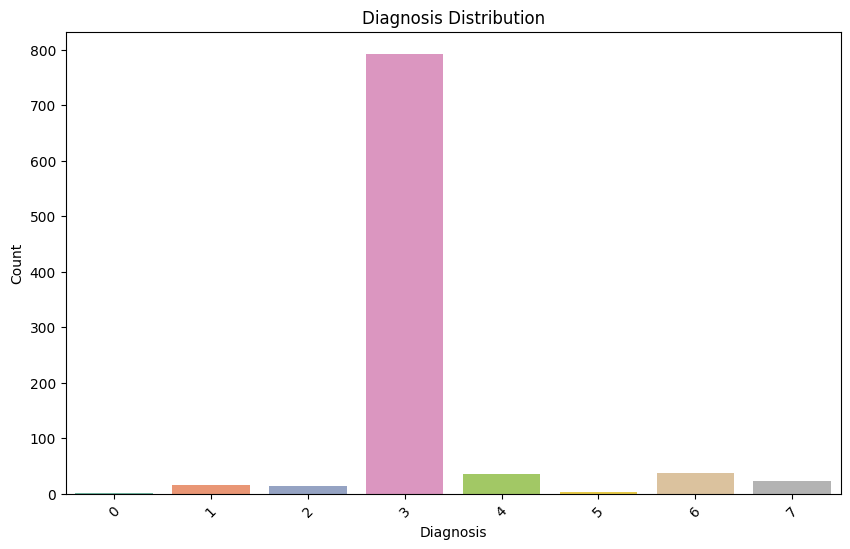

In [16]:
df_2 = df.copy()

le = LabelEncoder()

df_2['diagnosis'] = le.fit_transform(df_2['diagnosis'])

print(f"Target value counts: {df_2['diagnosis'].value_counts()}")

# plot target proportion using bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_2, x='diagnosis', palette='Set2')
plt.title('Diagnosis Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

We might do random undersampling, but for now we'll leave it as it is

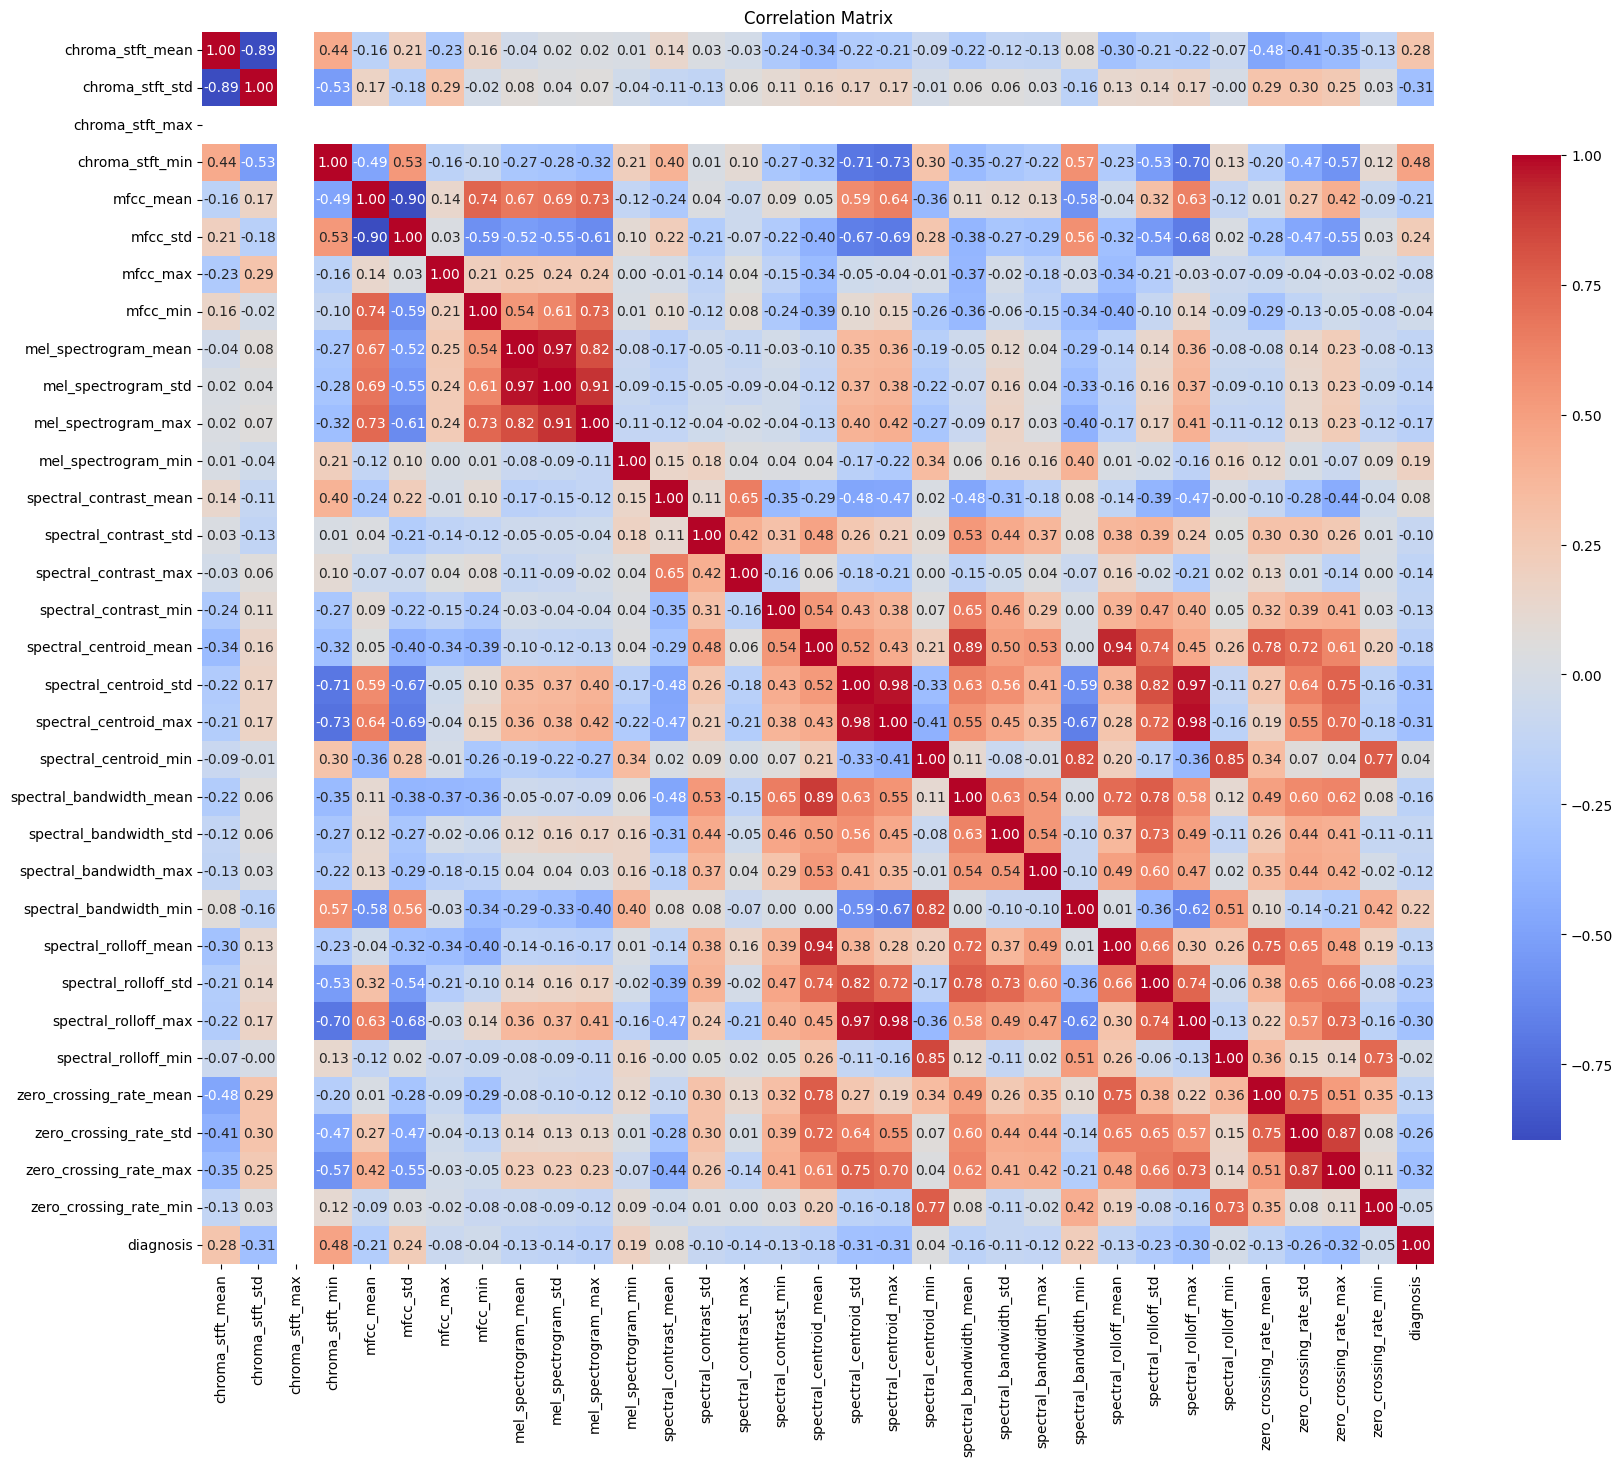

In [17]:
df_2 = df_2.drop(['filename'], axis=1)

corr_mat = df_2.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

We might do feature selection for numerical features only

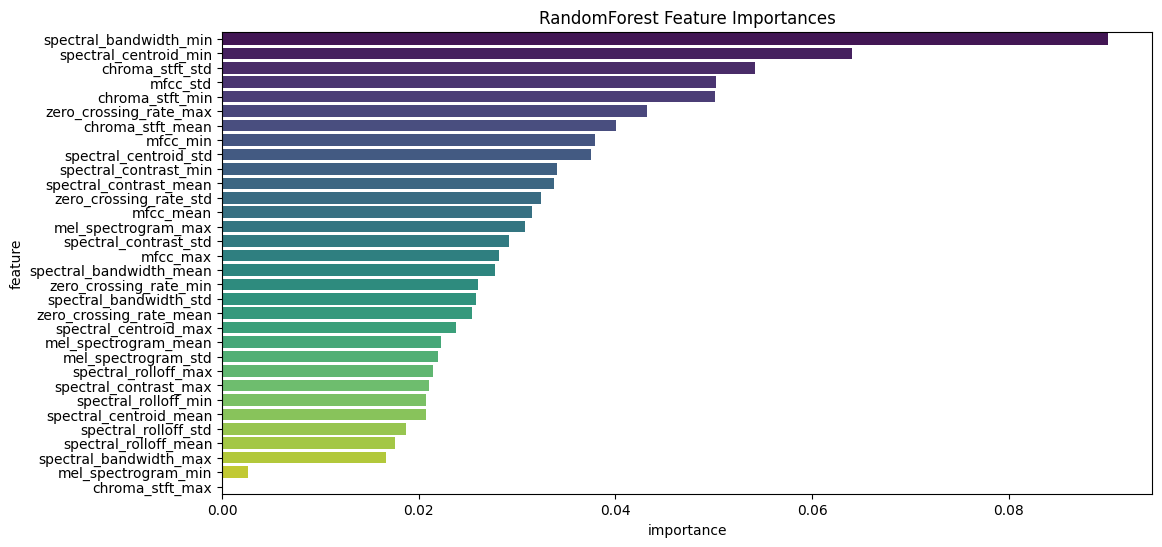

In [18]:
X = df.select_dtypes(exclude=['object'])
y = df['diagnosis'].values

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('RandomForest Feature Importances')
plt.show()

In [19]:
excluded_features = ['mel_spectrogram_min', 'chroma_stft_max']

X = X.drop(excluded_features, axis=1)

X.columns

Index(['chroma_stft_mean', 'chroma_stft_std', 'chroma_stft_min', 'mfcc_mean',
       'mfcc_std', 'mfcc_max', 'mfcc_min', 'mel_spectrogram_mean',
       'mel_spectrogram_std', 'mel_spectrogram_max', 'spectral_contrast_mean',
       'spectral_contrast_std', 'spectral_contrast_max',
       'spectral_contrast_min', 'spectral_centroid_mean',
       'spectral_centroid_std', 'spectral_centroid_max',
       'spectral_centroid_min', 'spectral_bandwidth_mean',
       'spectral_bandwidth_std', 'spectral_bandwidth_max',
       'spectral_bandwidth_min', 'spectral_rolloff_mean',
       'spectral_rolloff_std', 'spectral_rolloff_max', 'spectral_rolloff_min',
       'zero_crossing_rate_mean', 'zero_crossing_rate_std',
       'zero_crossing_rate_max', 'zero_crossing_rate_min'],
      dtype='object')

In [20]:
pd.Series(y).value_counts()

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

## 5. Modelling + Evaluation
We'll use `RandomForestClassifier` to build our machine learning model and optimize it using the Bayesian Optimization method using Optuna.

For the evaluation metrics, we'll use `f1_score` and `accuracy_score`!

[I 2025-04-15 07:50:05,447] A new study created in memory with name: no-name-dc07dab0-75ea-48aa-b9e2-3b4ffa8176ce


Class weights: {'Asthma': 115.0, 'Bronchiectasis': 7.1875, 'Bronchiolitis': 8.846153846153847, 'COPD': 0.1450189155107188, 'Healthy': 3.2857142857142856, 'LRTI': 57.5, 'Pneumonia': 3.108108108108108, 'URTI': 5.0}
Starting hyperparameter optimization...


[I 2025-04-15 07:50:07,528] Trial 0 finished with value: 0.8588076155649164 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 0 with value: 0.8588076155649164.
[I 2025-04-15 07:50:11,266] Trial 1 finished with value: 0.874572123663172 and parameters: {'n_estimators': 249, 'max_depth': 37, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.874572123663172.
[I 2025-04-15 07:50:13,560] Trial 2 finished with value: 0.8588016179763972 and parameters: {'n_estimators': 128, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 1 with value: 0.874572123663172.
[I 2025-04-15 07:50:16,008] Trial 3 finished with value: 0.8795201267945731 and parameters: {'n_estimators': 164, 'max_depth': 36, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 3 with value: 0.8795201267945731.


Best F1 Score: 0.9150
Best hyperparameters:
    n_estimators: 205
    max_depth: 29
    min_samples_split: 8
    min_samples_leaf: 3
    max_features: sqrt

Evaluating optimized model with cross-validation:

Fold 1:
Train set size: 736, Test set size: 184
Train target distribution:
COPD              634
Pneumonia          30
Healthy            28
URTI               18
Bronchiectasis     13
Bronchiolitis      10
LRTI                2
Asthma              1
Name: count, dtype: int64
Test target distribution:
COPD              159
Pneumonia           7
Healthy             7
URTI                5
Bronchiolitis       3
Bronchiectasis      3
Name: count, dtype: int64
--------------------------------------------------
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.75      1.00      0.86         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.99      0.98      0.99       159
       Healthy       0.44      

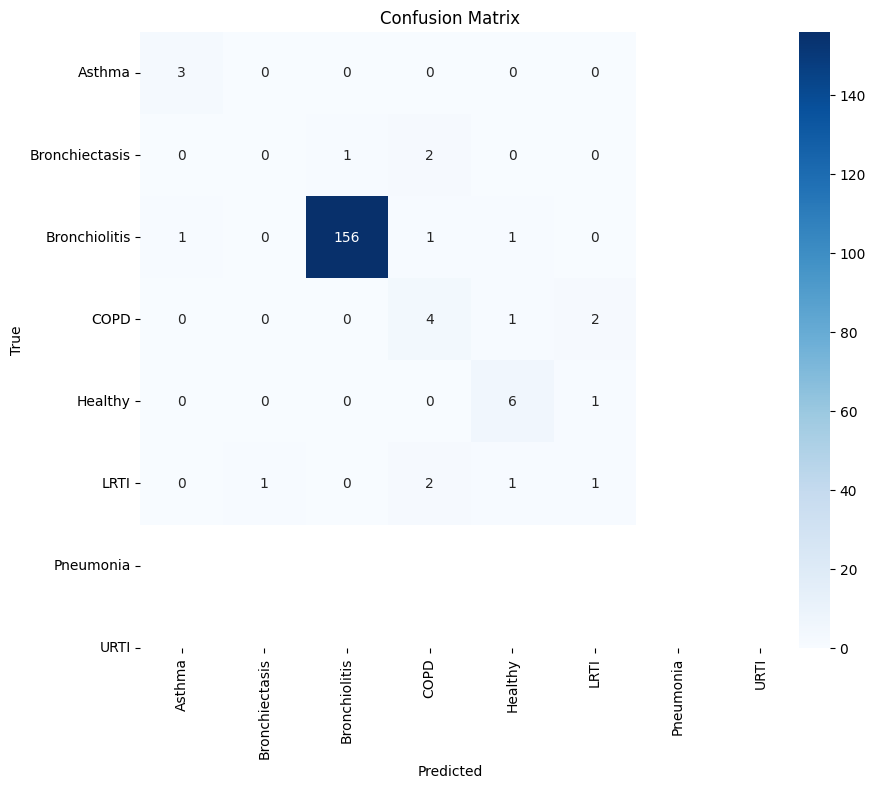


Fold 2:
Train set size: 736, Test set size: 184
Train target distribution:
COPD              634
Pneumonia          30
Healthy            28
URTI               18
Bronchiectasis     13
Bronchiolitis      10
LRTI                2
Asthma              1
Name: count, dtype: int64
Test target distribution:
COPD              159
Pneumonia           7
Healthy             7
URTI                5
Bronchiectasis      3
Bronchiolitis       3
Name: count, dtype: int64
--------------------------------------------------
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       1.00      0.67      0.80         3
 Bronchiolitis       0.50      0.33      0.40         3
          COPD       0.97      0.97      0.97       159
       Healthy       0.67      0.86      0.75         7
     Pneumonia       0.62      0.71      0.67         7
          URTI       0.50      0.40      0.44         5

      accuracy                           0.92       184
     macro avg

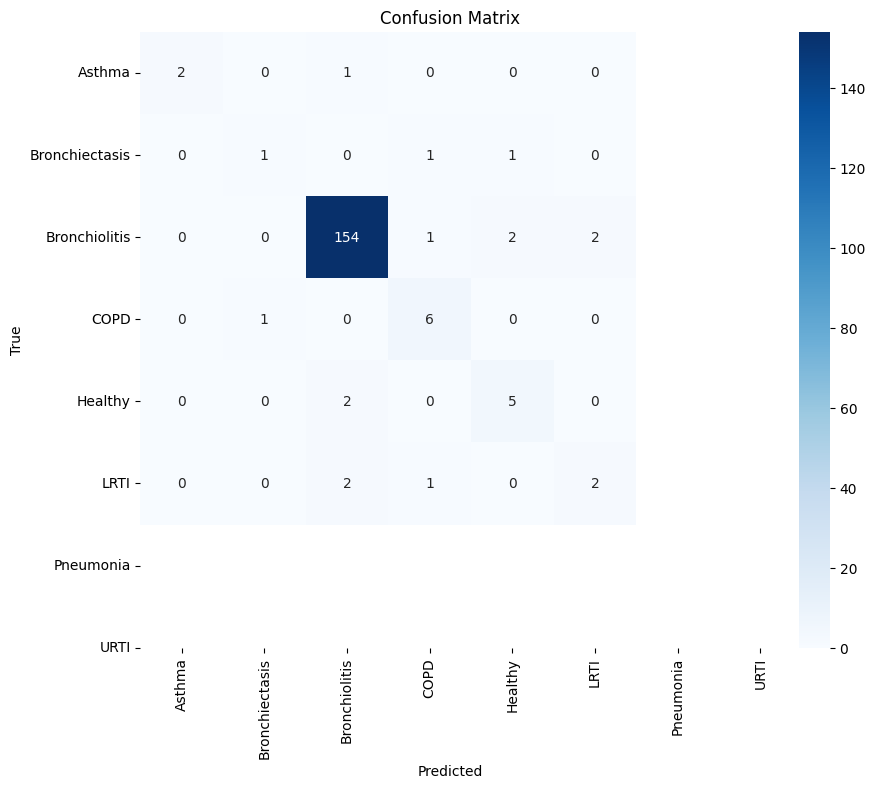


Fold 3:
Train set size: 736, Test set size: 184
Train target distribution:
COPD              634
Pneumonia          29
Healthy            28
URTI               19
Bronchiectasis     13
Bronchiolitis      11
LRTI                2
Name: count, dtype: int64
Test target distribution:
COPD              159
Pneumonia           8
Healthy             7
URTI                4
Bronchiectasis      3
Bronchiolitis       2
Asthma              1
Name: count, dtype: int64
--------------------------------------------------
Classification Report:
                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         1
Bronchiectasis       1.00      1.00      1.00         3
 Bronchiolitis       0.00      0.00      0.00         2
          COPD       1.00      0.96      0.98       159
       Healthy       0.50      0.57      0.53         7
     Pneumonia       0.41      0.88      0.56         8
          URTI       0.33      0.25      0.29         4

      accuracy

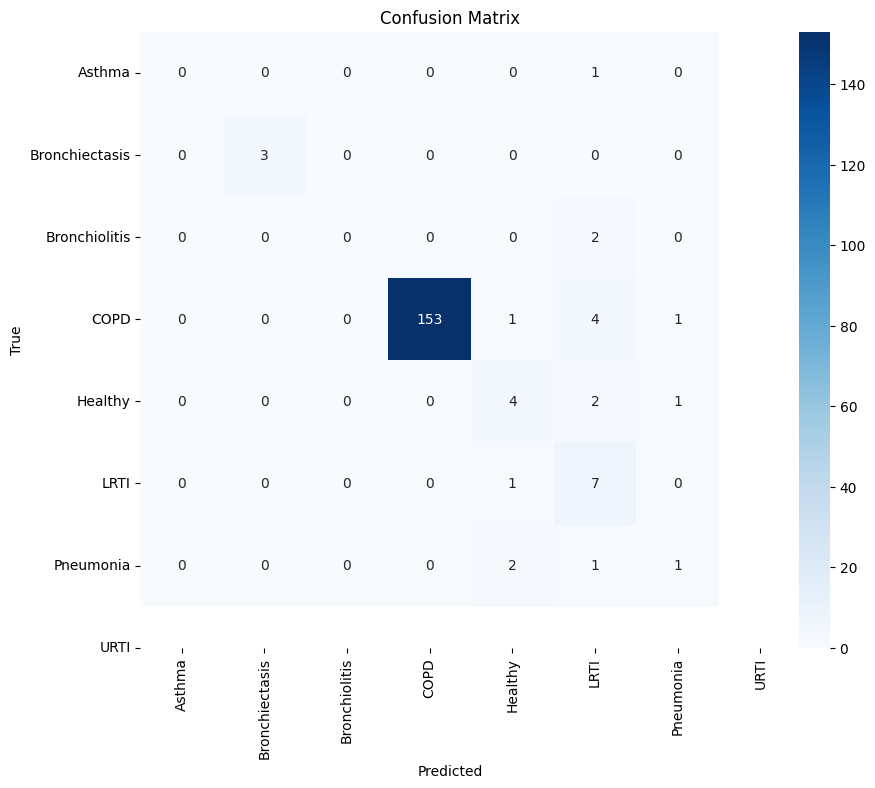


Fold 4:
Train set size: 736, Test set size: 184
Train target distribution:
COPD              635
Pneumonia          29
Healthy            28
URTI               19
Bronchiectasis     12
Bronchiolitis      11
Asthma              1
LRTI                1
Name: count, dtype: int64
Test target distribution:
COPD              158
Pneumonia           8
Healthy             7
Bronchiectasis      4
URTI                4
Bronchiolitis       2
LRTI                1
Name: count, dtype: int64
--------------------------------------------------
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       1.00      1.00      1.00         4
 Bronchiolitis       1.00      0.50      0.67         2
          COPD       1.00      0.97      0.98       158
       Healthy       0.33      0.43      0.38         7
          LRTI       0.00      0.00      0.00         1
     Pneumonia       0.42      0.62      0.50         8
          URTI       0.20      0.25      0.22    

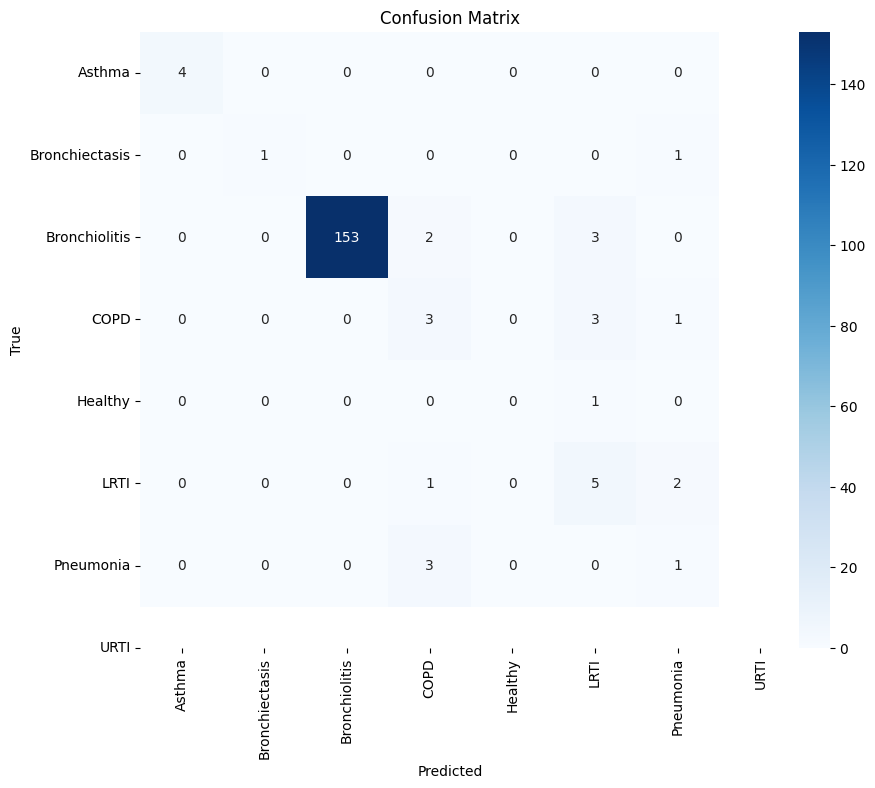


Fold 5:
Train set size: 736, Test set size: 184
Train target distribution:
COPD              635
Pneumonia          30
Healthy            28
URTI               18
Bronchiectasis     13
Bronchiolitis      10
Asthma              1
LRTI                1
Name: count, dtype: int64
Test target distribution:
COPD              158
Pneumonia           7
Healthy             7
URTI                5
Bronchiolitis       3
Bronchiectasis      3
LRTI                1
Name: count, dtype: int64
--------------------------------------------------
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       1.00      1.00      1.00         3
 Bronchiolitis       1.00      0.33      0.50         3
          COPD       0.99      0.94      0.96       158
       Healthy       0.45      0.71      0.56         7
          LRTI       0.00      0.00      0.00         1
     Pneumonia       0.39      1.00      0.56         7
          URTI       0.50      0.20      0.29    

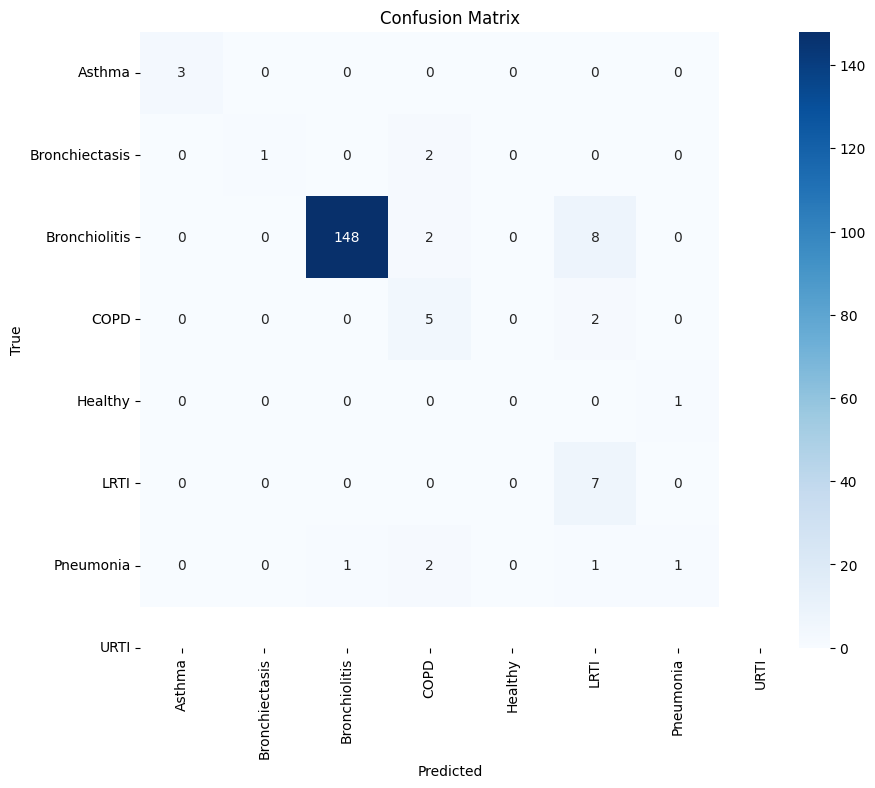

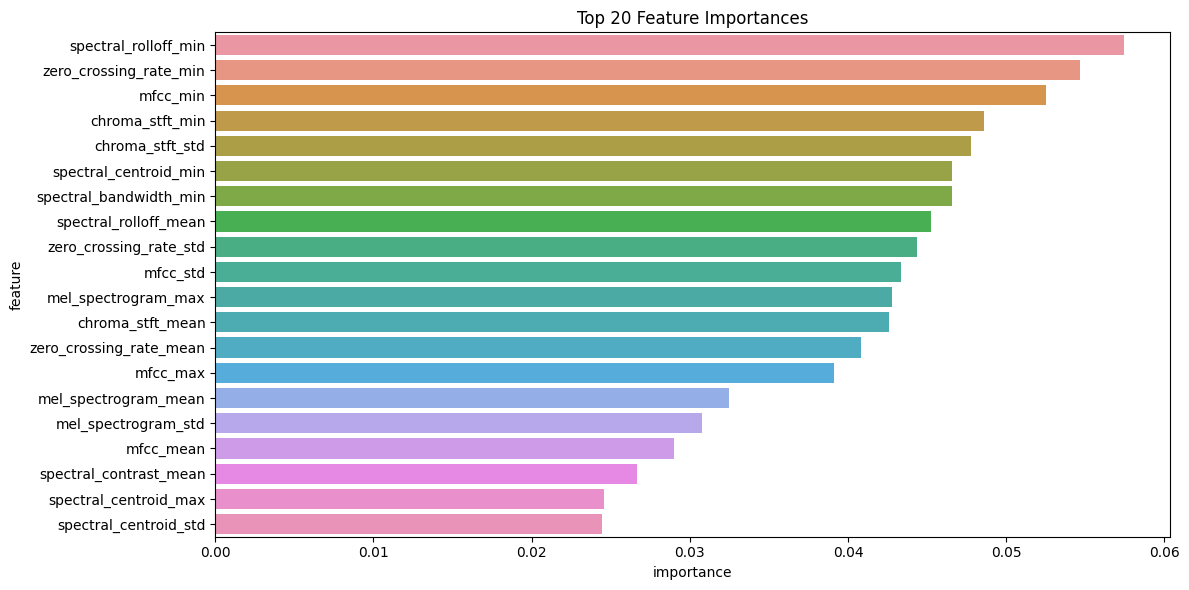

Mean F1 Score across all folds: 0.9150
Mean Accuracy Score across all folds: 0.9130


In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights_dict = dict(zip(np.unique(y), class_weights))
print(f"Class weights: {class_weights_dict}")

def objective(trial):
    """Objective function for hyperparameter optimization"""
    # define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    
    cv_scores = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        rf = RandomForestClassifier(
            **params,
            random_state=42,
            class_weight=class_weights_dict,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cv_scores.append(f1)
    
    return np.mean(cv_scores)

# run optuna study
print("Starting hyperparameter optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# get best parameters
best_params = study.best_params
print(f"\nBest F1 Score: {study.best_value:.4f}")
print("Best hyperparameters:")
for param, value in best_params.items():
    print(f"    {param}: {value}")

# evaluate optimized model with cross-validation
print("\nEvaluating optimized model with cross-validation:")
all_f1_scores = []
all_accuracy_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    print(f"\nFold {fold}:")
    print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
    print(f"Train target distribution:\n{pd.Series(y_train).value_counts()}")
    print(f"Test target distribution:\n{pd.Series(y_test).value_counts()}")
    print("-" * 50)
    
    # train optimized model
    rf_optimized = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42,
        class_weight=class_weights_dict,
        n_jobs=-1
    )
    rf_optimized.fit(X_train, y_train)
    
    # predict
    y_pred = rf_optimized.predict(X_test)
    
    # print metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    f1 = f1_score(y_test, y_pred, average='weighted') # calculate F1 score
    accuracy = accuracy_score(y_test, y_pred) # calculate accuracy
    
    all_f1_scores.append(f1)
    all_accuracy_scores.append(accuracy)
    
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y), 
                yticklabels=np.unique(y))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # if last fold, show feature importance
    if fold == 5:
        feature_importances = pd.DataFrame({
            'feature': X.columns,
            'importance': rf_optimized.feature_importances_
        }).sort_values(by='importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
        plt.title('Top 20 Feature Importances')
        plt.tight_layout()
        plt.show()

print(f'Mean F1 Score across all folds: {np.mean(all_f1_scores):.4f}')
print(f'Mean Accuracy Score across all folds: {np.mean(all_accuracy_scores):.4f}')

In [22]:
# custom transformer to load audio files
class AudioLoader(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Load audio files from a list of file paths"""
        result = {}
        for file_path in X:
            filename = file_path.split('\\')[-1] if '\\' in file_path else file_path.split('/')[-1]
            y, sr = librosa.load(file_path, mono=True)
            result[filename] = {'data': y, 'sample_rate': sr}
        return result

# custom transformer to trim audio to consistent duration
class AudioTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self, target_duration=7.8560090702947845):  # default duration in seconds
        self.target_duration = target_duration
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Trim audio files to consistent duration"""
        trimmed = {}
        for filename, audio_info in X.items():
            target_samples = int(self.target_duration * audio_info['sample_rate'])
            
            # if audio is shorter than target, pad with zeros
            if len(audio_info['data']) < target_samples:
                trimmed_data = np.pad(audio_info['data'], 
                                     (0, target_samples - len(audio_info['data'])), 
                                     'constant')
            else:
                trimmed_data = audio_info['data'][:target_samples]
            
            trimmed[filename] = {
                'data': trimmed_data,
                'sample_rate': audio_info['sample_rate'],
                'duration': self.target_duration
            }
        return trimmed

# custom transformer to extract audio features
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Extract audio features"""
        features = {}
        for filename, audio_info in X.items():
            y_audio = audio_info['data']
            sr = audio_info['sample_rate']
            
            features[filename] = {}
            features[filename]['chroma_stft'] = librosa.feature.chroma_stft(y=y_audio, sr=sr)
            features[filename]['mfcc'] = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13)
            features[filename]['mel_spectrogram'] = librosa.feature.melspectrogram(y=y_audio, sr=sr)
            features[filename]['spectral_contrast'] = librosa.feature.spectral_contrast(y=y_audio, sr=sr)
            features[filename]['spectral_centroid'] = librosa.feature.spectral_centroid(y=y_audio, sr=sr)
            features[filename]['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=y_audio, sr=sr)
            features[filename]['spectral_rolloff'] = librosa.feature.spectral_rolloff(y=y_audio, sr=sr)
            features[filename]['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y=y_audio)
            
        return features

# custom transformer to calculate feature statistics
class FeatureStatisticsCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, excluded_features=None):
        self.excluded_features = excluded_features or []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Calculate statistics for each feature"""
        feature_stats = []
        for filename, features in X.items():
            file_stats = {'filename': filename}
            
            for feature_name, feature_data in features.items():
                file_stats[f'{feature_name}_mean'] = np.mean(feature_data)
                file_stats[f'{feature_name}_std'] = np.std(feature_data)
                file_stats[f'{feature_name}_max'] = np.max(feature_data)
                file_stats[f'{feature_name}_min'] = np.min(feature_data)
            
            feature_stats.append(file_stats)
        
        # create dataframe
        df = pd.DataFrame(feature_stats)
        
        # exclude features if specified
        for feature in self.excluded_features:
            if feature in df.columns:
                df = df.drop(feature, axis=1)
                
        # keep only numeric columns for prediction
        return df.select_dtypes(exclude=['object'])

# save the trained Random Forest model
def save_model(model, filename='../breathelytics-backend/respiratory_classifier.pkl'):
    """Save the trained model"""
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

# function to create and save respiratory classification pipeline
def create_respiratory_pipeline():
    """Create a pipeline for respiratory sound classification"""
    # define excluded features based on previous analysis
    excluded_features = ['mel_spectrogram_min', 'chroma_stft_max']
    
    # build the preprocessing pipeline only
    preprocessing_pipeline = Pipeline([
        ('load_audio', AudioLoader()),
        ('trim_audio', AudioTrimmer(target_duration=7.8560090702947845)),  # Use a standard duration
        ('extract_features', FeatureExtractor()),
        ('calculate_statistics', FeatureStatisticsCalculator(excluded_features=excluded_features))
    ])
    
    return preprocessing_pipeline

# function to predict respiratory condition using the saved model
def predict_respiratory_condition(wav_file_path, model_path='../breathelytics-backend/respiratory_classifier.pkl'):
    """Predict respiratory condition from a WAV file using a saved model"""
    # load the saved model
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found")
    
    model = joblib.load(model_path)
    
    # create preprocessing pipeline
    preprocessing_pipeline = create_respiratory_pipeline()
    
    # process the audio file
    features_df = preprocessing_pipeline.transform([wav_file_path])
    
    # make prediction
    prediction = model.predict(features_df)[0]
    probabilities = model.predict_proba(features_df)[0]
    
    # get the class with highest probability and its probability value
    max_prob = np.max(probabilities)
    classes = model.classes_
    
    return {
        'prediction': prediction,
        'probability': max_prob,
        'all_probabilities': dict(zip(classes, probabilities))
    }

In [23]:
# save  trained RF model
save_model(rf_optimized)

Model saved as respiratory_classifier.pkl


## 6. Testing

In [24]:
df[['filename','diagnosis']].sample(random_state=12)

,filename,diagnosis
301,122_2b1_Al_mc_LittC2SE.wav,Pneumonia


In [25]:
# pipeline usage
result = predict_respiratory_condition('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/122_2b1_Al_mc_LittC2SE.wav',
                                       model_path='../breathelytics-backend/respiratory_classifier.pkl')
print(f"Predicted condition: {result['prediction']} (confidence: {result['probability']:.2f})")

Predicted condition: Healthy (confidence: 0.42)


Our prediction is correct! We're done now :)